In [ ]:
# Load externals
from models import unet, BASIC_D
import utils
from keras import optimizers, losses
from keras import backend as K

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as im

import numpy as np


# Deets and parameters
nc_in = 1
nc_out = 1
ngf = 64
ndf = 64

loadSize = 125
imageSize = 128
batchSize = 16
lrG = 2e-4
lrD = 2e-4

netG = unet(imageSize, nc_in, nc_out, ngf)
netG.summary()

netD = BASIC_D(nc_in, nc_out, ndf)
netD.summary()

# Run this cell and the one below before running results from a fresh kernal and model load

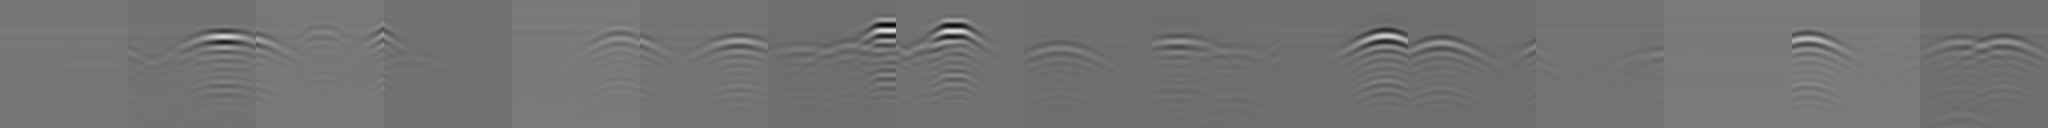

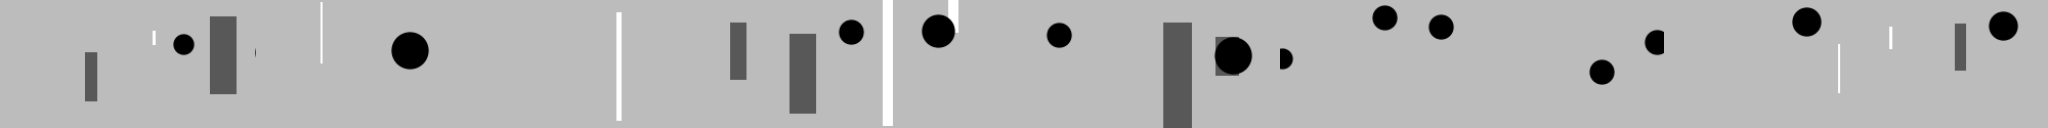

In [9]:
import utils as ut
data = "air-water-rebar_balanced"
direction = 1
test = './datasets/{}/train/*.png'.format(data)
trainAB = ut.load_data('./datasets/{}/train/*.png'.format(data))
valAB = ut.load_data('./datasets/{}/val/*.png'.format(data))

loadSize = 125
imageSize = 128
batchSize = 16
lrG = 2e-4
lrD = 2e-4

# Purely for testing and showing test batch
train_batch = ut.minibatch(trainAB, batchSize, imageSize, imageSize, direction=direction)
test_epoch, trainA, trainB = next(train_batch)
ut.show_batch_grayscale(trainA, imageSize)
ut.show_batch_grayscale(trainB, imageSize)
#del train_batch, trainA, trainB, test_epoch

If you want to use a loss function that is not of the form of f(x_true, x_pred), then you have to implement your training routine outside of Keras.

Basically:

1. define your model (typically using the functional API)
2. define your custom cost
3. instantiate an optimizer, get weights updates via:  
   updates = optimizer.get_updates(model.trainable_weights, model.constraints, cost))
4. take care manually of regularizers and batchnorm updates
5. create your own Keras functions based on the inputs, outputs, and updates

In [11]:
from keras.optimizers import Adam
from keras import backend as K

def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

# Loss function

loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))

loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

# Training

In [ ]:
import time
from IPython.display import clear_output
import numpy as np

t0 = time.time()
niter = 1
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

import time
from IPython.display import clear_output
t0 = time.time()
niter = 5
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0
current_epoch = 0

display_iters = 900
# based on 28800 dataset, minibatch 16, ~240 sec for 900 which is half an epoch
# 1 epoch is approx 480sec or 8 minutes
val_batch = ut.minibatch(valAB, 6, imageSize, imageSize, direction)
train_batch = ut.minibatch(trainAB, batchSize, imageSize, imageSize, direction)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch) 
    trainA = trainA.reshape(batchSize, imageSize, imageSize, 1)
    trainB = trainB.reshape(batchSize, imageSize, imageSize, 1)
    errD = netD_train([trainA, trainB])
    errD_sum +=sum(errD)

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        valAtemp = valA.reshape(6, imageSize, imageSize, 1)
        fakeB = netG_gen(valAtemp)
        fakeB = fakeB.reshape(6, imageSize,imageSize)
        ut.show_batch_grayscale(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)
        errL1_sum = errG_sum = errD_sum = 0
        
        _, valA, valB = next(val_batch)
        valAtemp = valA.reshape(6, imageSize, imageSize, 1)
        fakeB = netG_gen(valAtemp)
        fakeB = fakeB.reshape(6, imageSize,imageSize)
        ut.show_batch_grayscale(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)
    
    # save latest epoch
    if epoch > current_epoch:
        netD.save('./models/netD')
        netG.save('./models/netG')
        
        current_epoch = epoch

# Save at the end
netD.save('./models/netD')
netG.save('./models/netG')

In [ ]:
# Preliminary test. Shows a sample from training dataset and validation dataset
_, valA, valB = train_batch.send(6) 
valAtemp = valA.reshape(6, imageSize, imageSize, 1)
fakeB = netG_gen(valAtemp)
fakeB = fakeB.reshape(6, imageSize,imageSize)
ut.show_batch_grayscale(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)

_, valA, valB = next(val_batch)
valAtemp = valA.reshape(6, imageSize, imageSize, 1)
fakeB = netG_gen(valAtemp)
fakeB = fakeB.reshape(6, imageSize,imageSize)
ut.show_batch_grayscale(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)

In [ ]:
_, valA, valB = train_batch.send(6) 
fakeB = netG_gen(valA)
ut.show_batch(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)
errL1_sum = errG_sum = errD_sum = 0
_, valA, valB = next(val_batch)
fakeB = netG_gen(valA)
ut.show_batch(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)

### Saving and Loading Model Testing

Try and combine both the discriminator and generator into one model. (Future)

In [ ]:
# Test save model
netD.save('./models/netD.h5')
netG.save('./models/netG.h5')

In [1]:
# Test load model
from keras.models import load_model

netD = load_model('./models/netD.h5')
netG = load_model('./models/netG.h5')

Using TensorFlow backend.
/home/jk/Softwares/miniconda3/envs/keras/lib/python3.5/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Results

Run validation test set through the generator network and save the resulting image

### Order - (For fresh kernel and/or model load)
1. Run "Test load model cell"
2. Run the big cell that says to load it and the one below it.
3. Then run the cell below. 

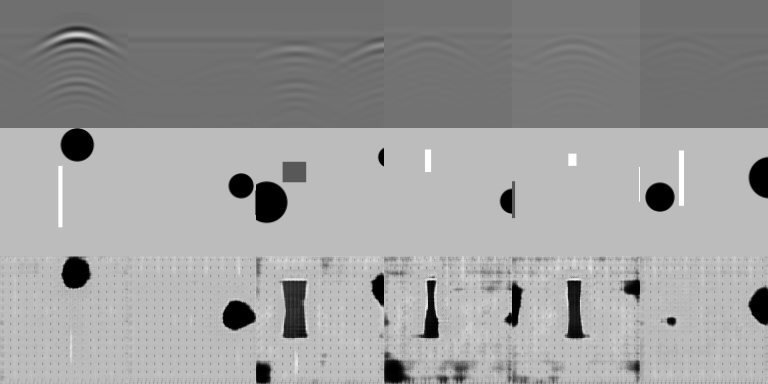

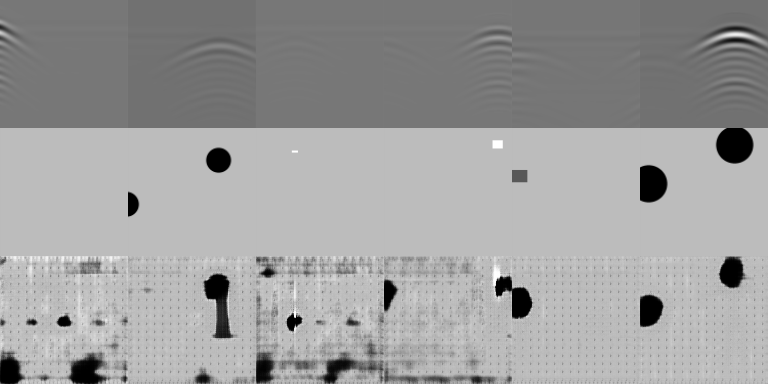

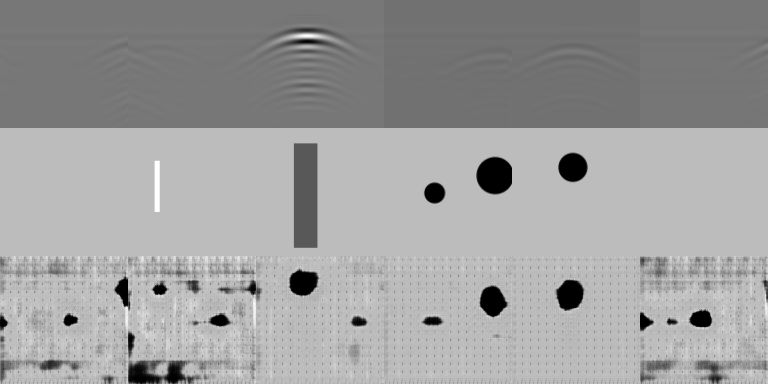

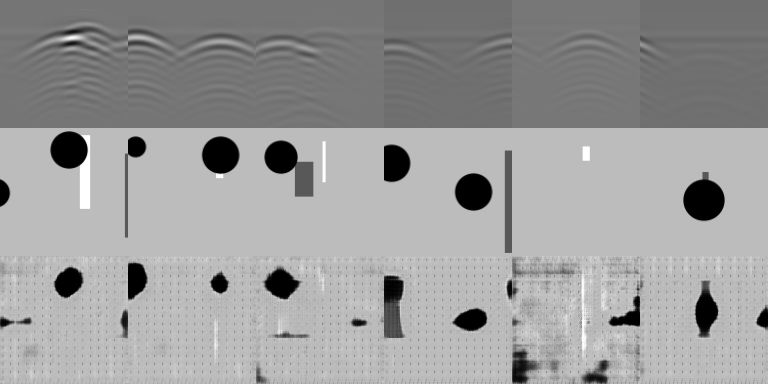

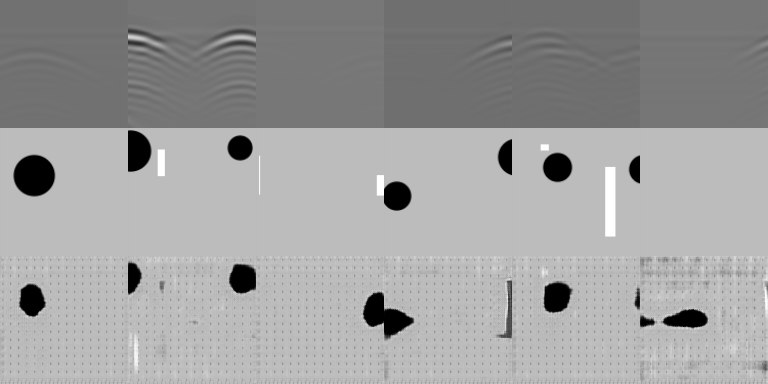

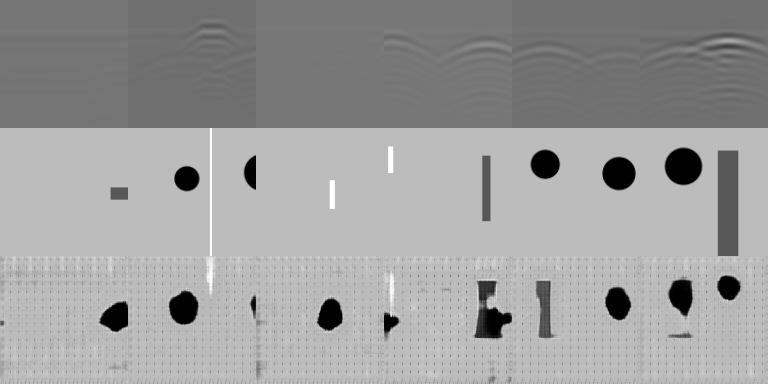

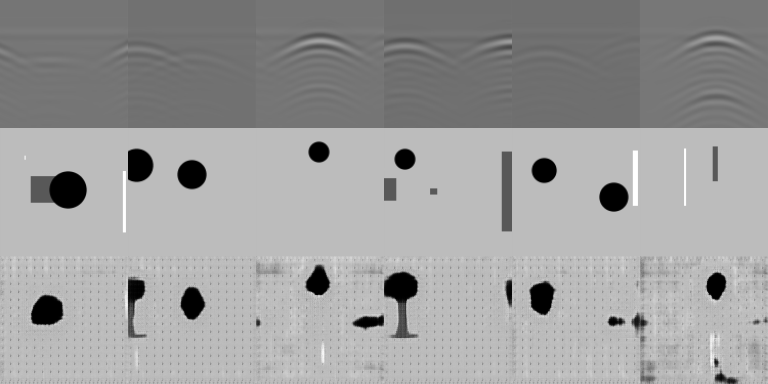

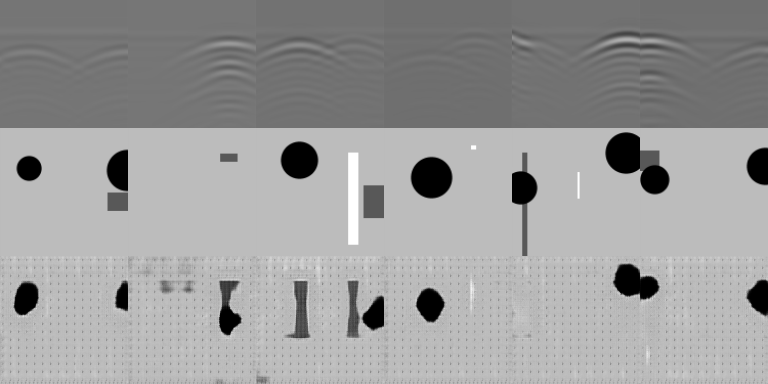

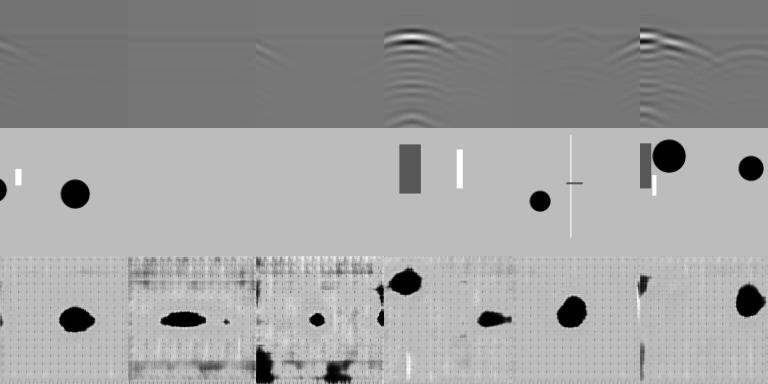

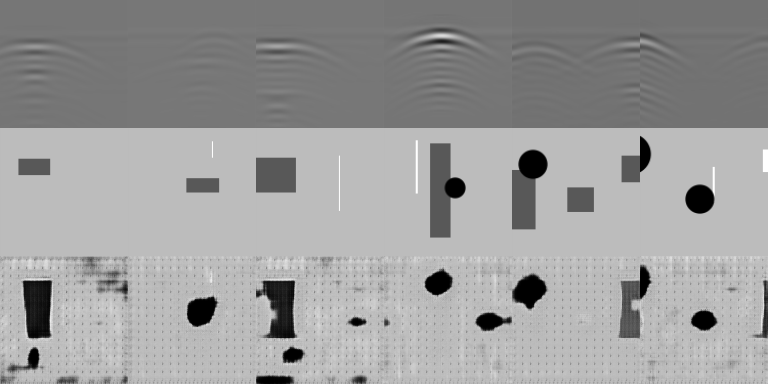

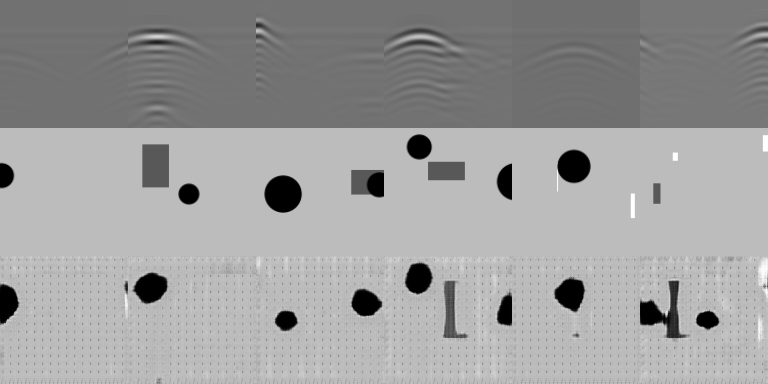

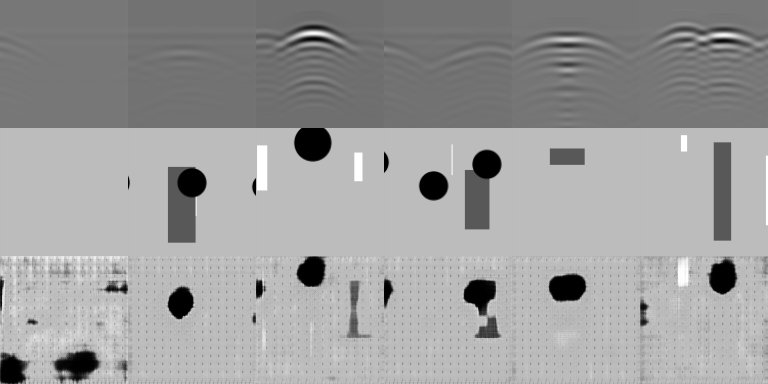

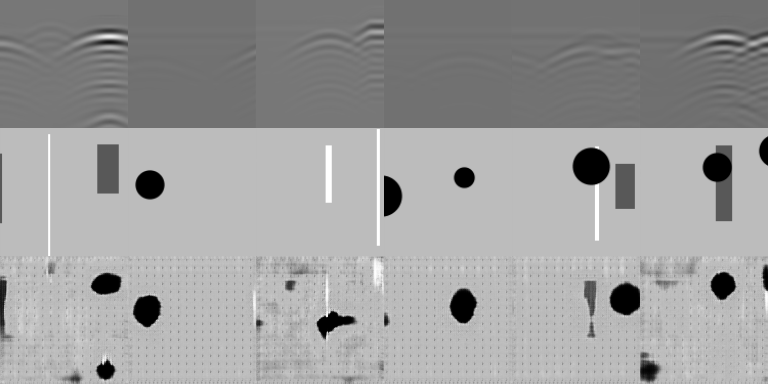

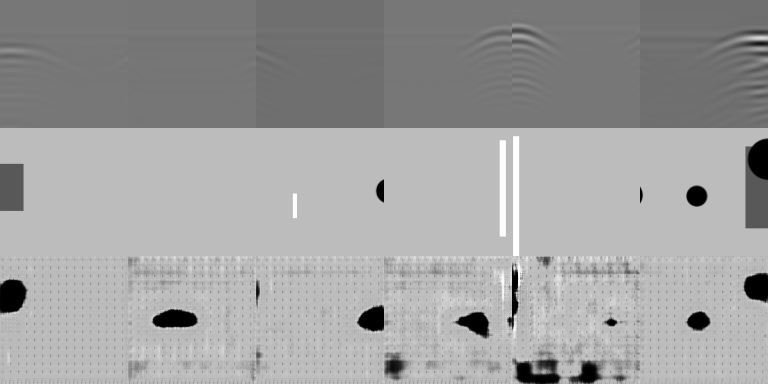

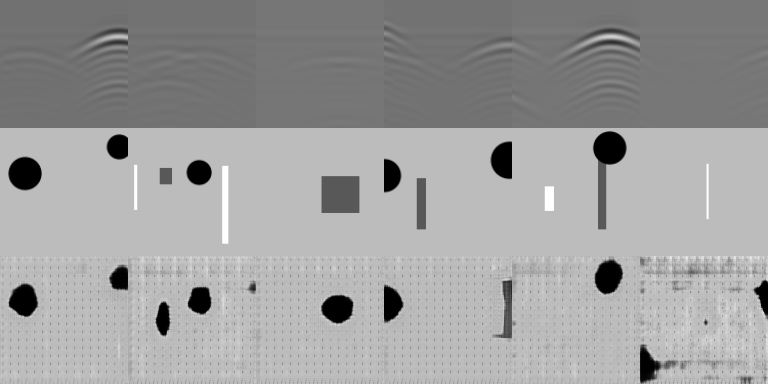

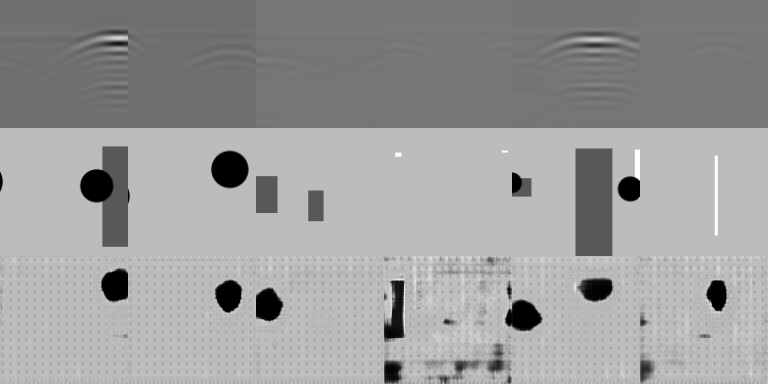

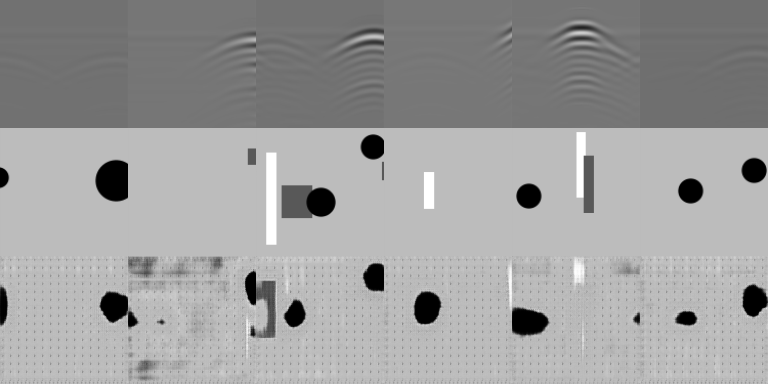

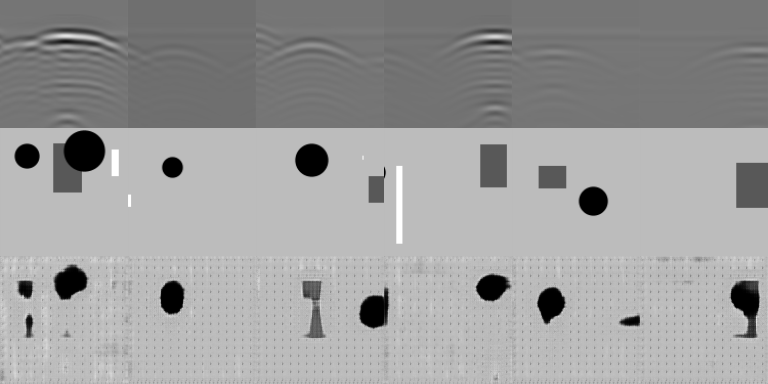

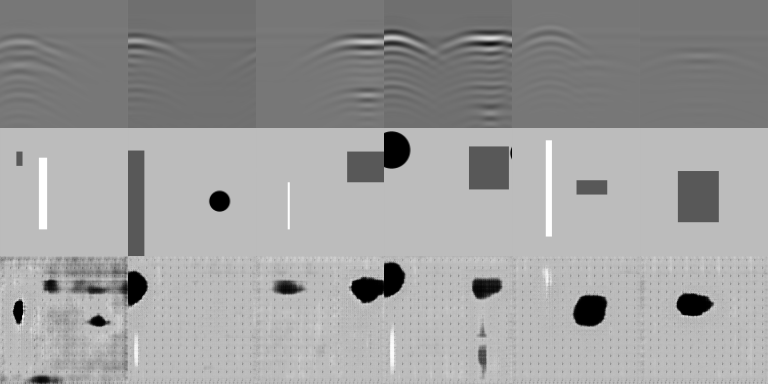

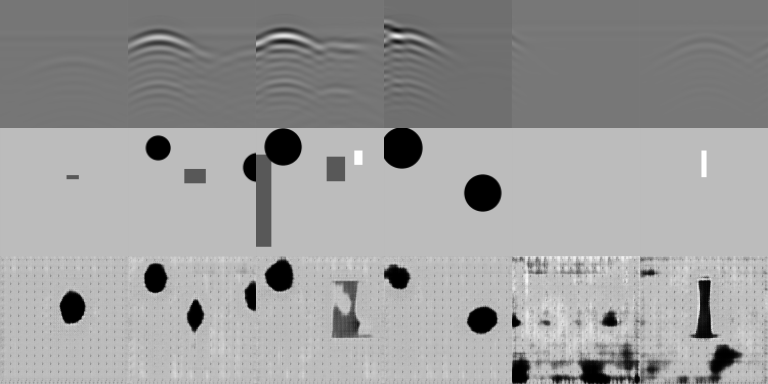

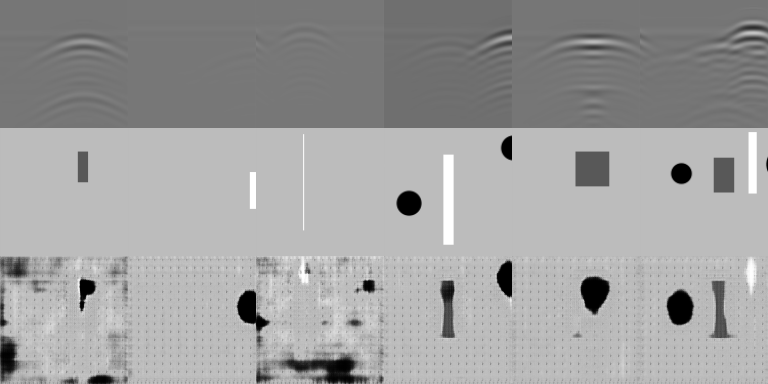

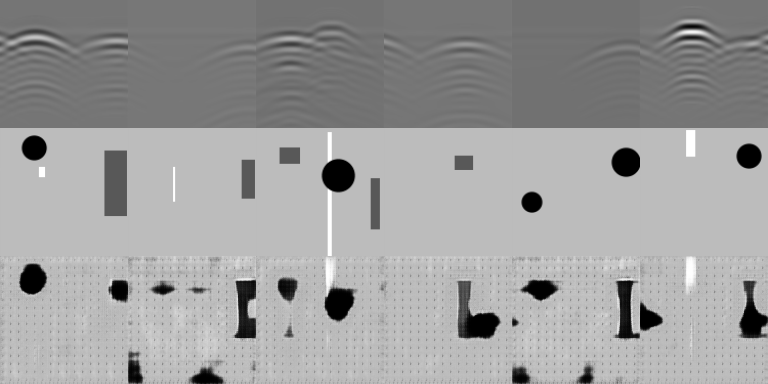

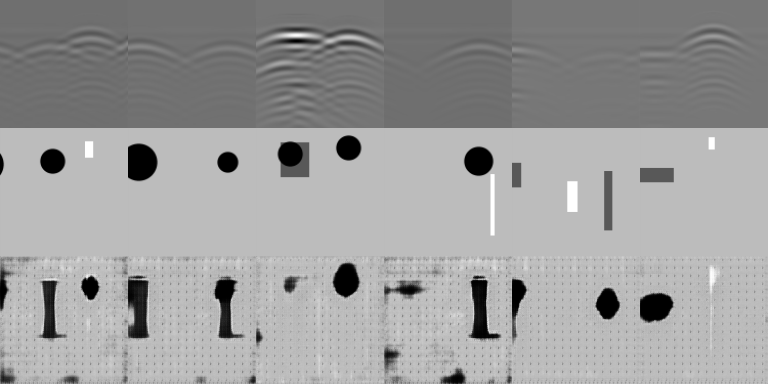

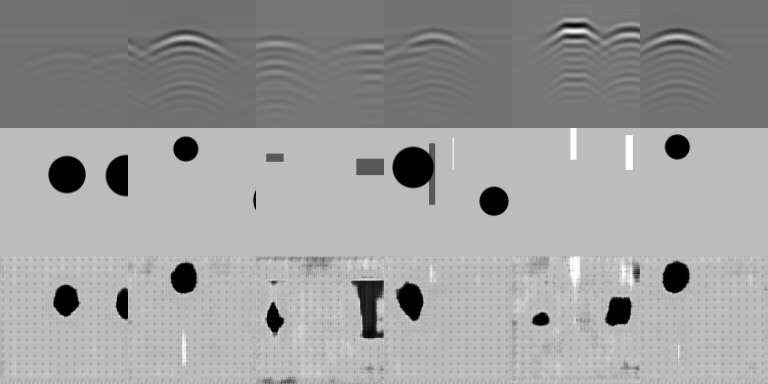

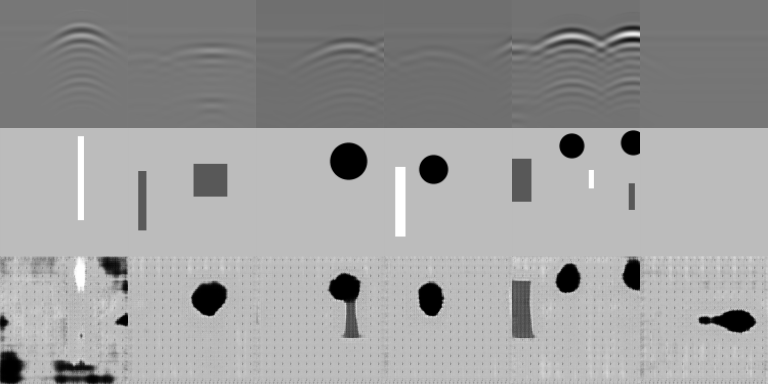

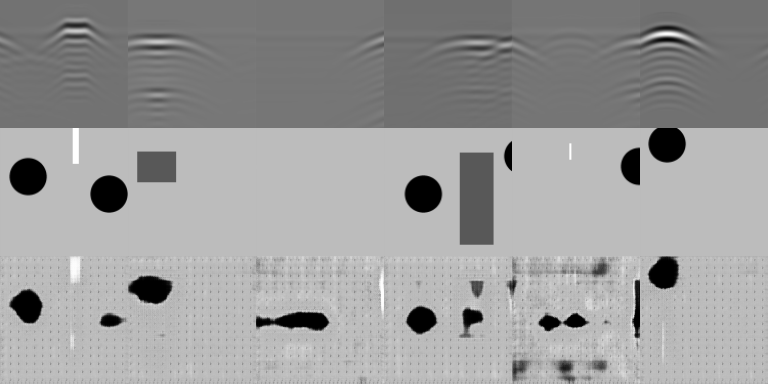

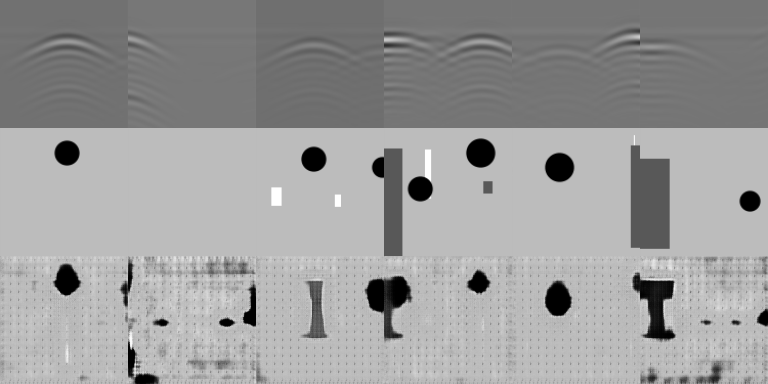

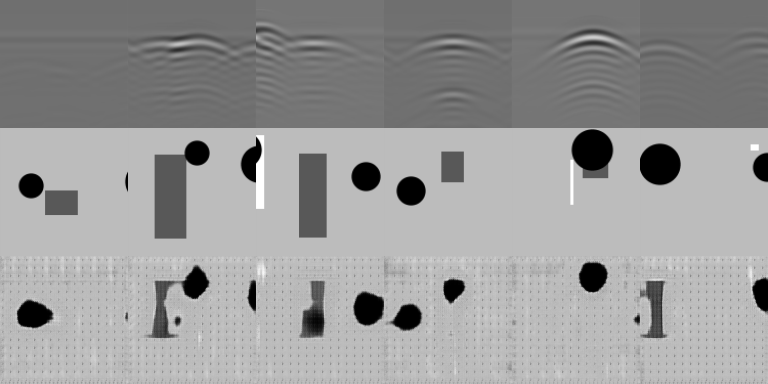

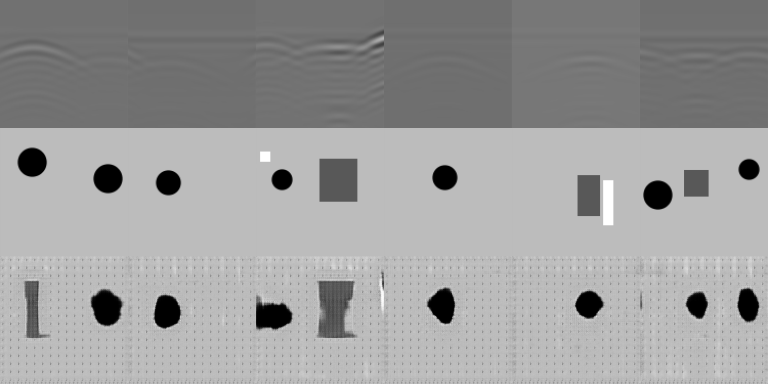

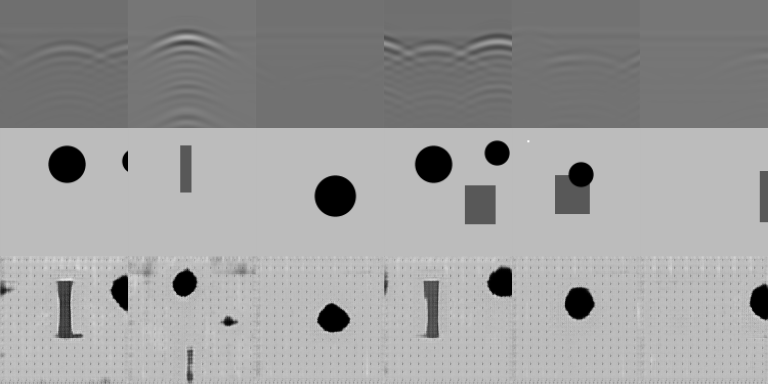

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


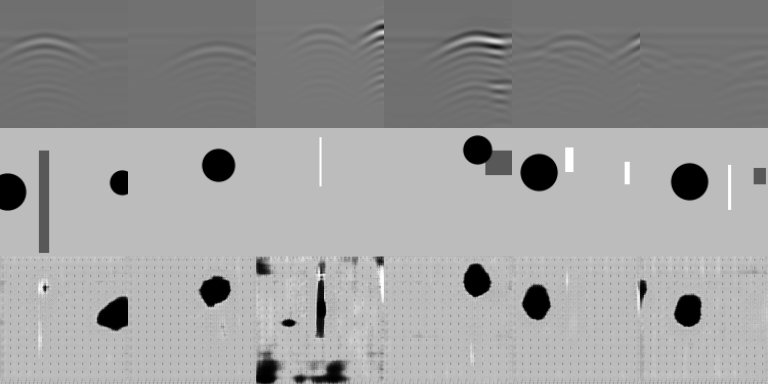

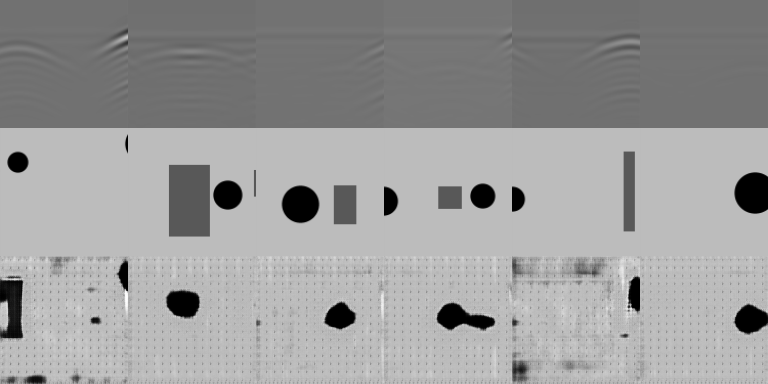

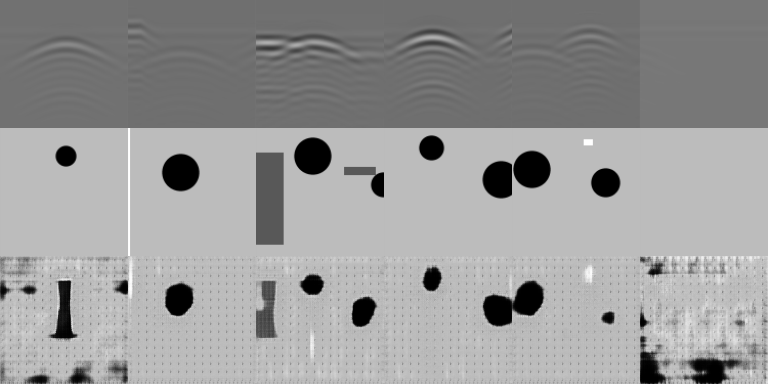

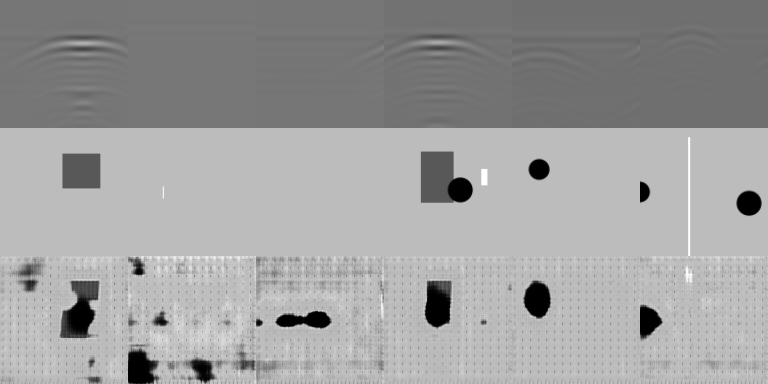

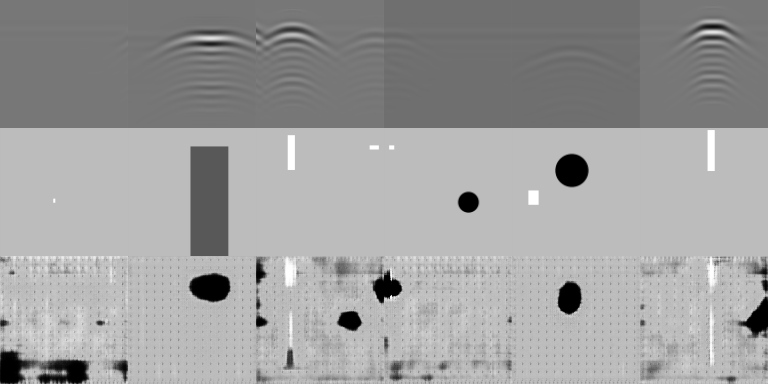

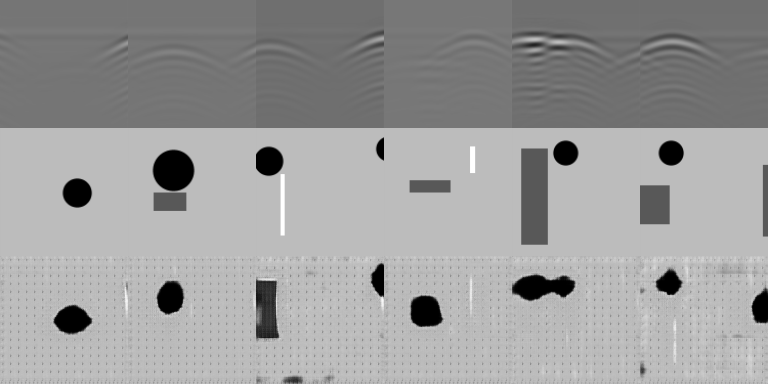

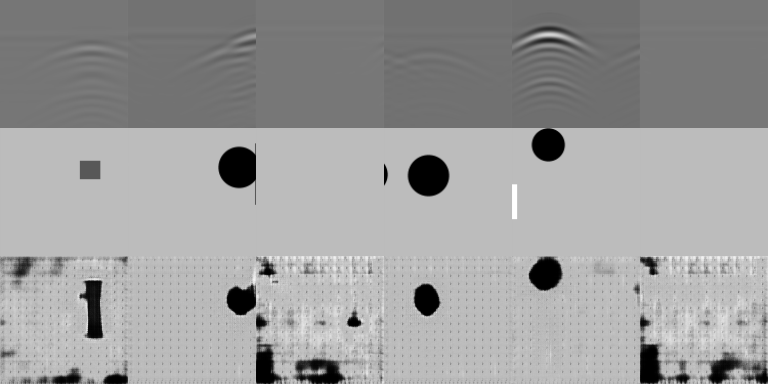

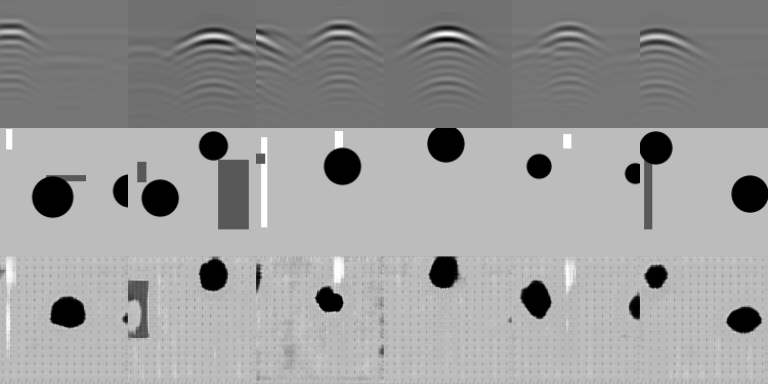

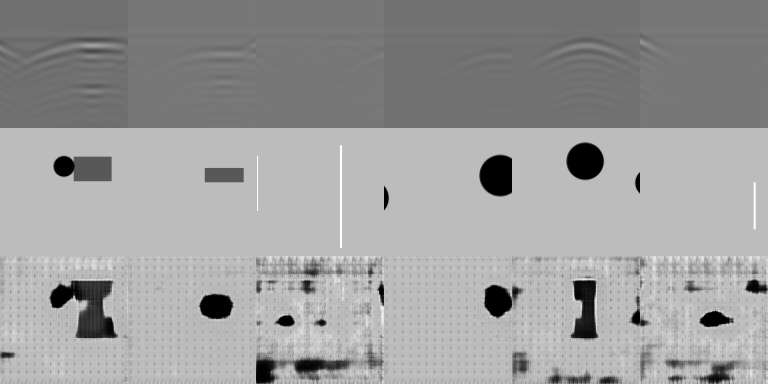

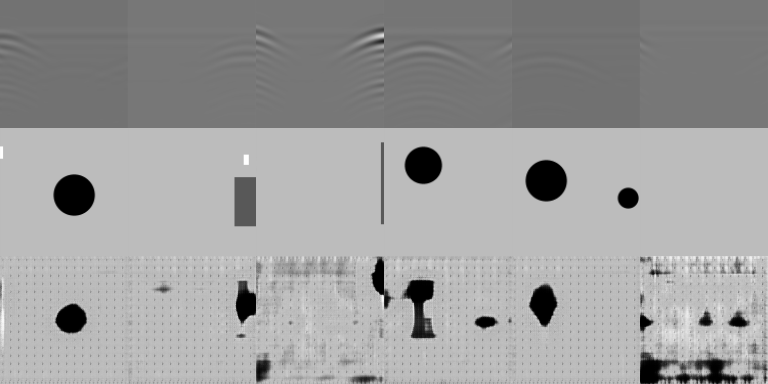

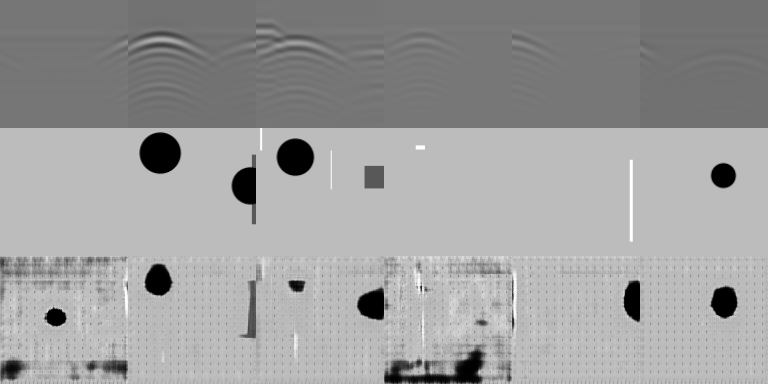

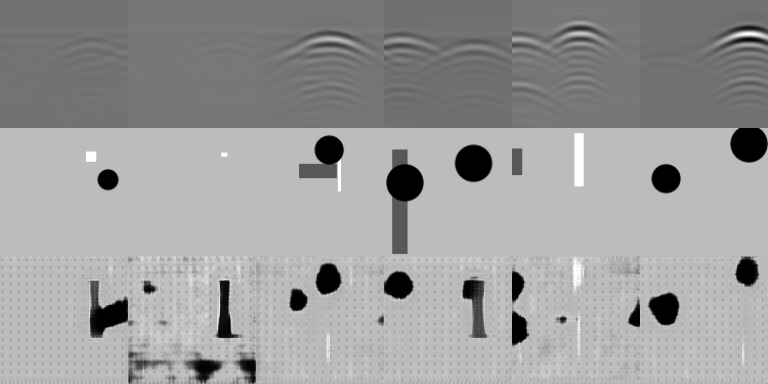

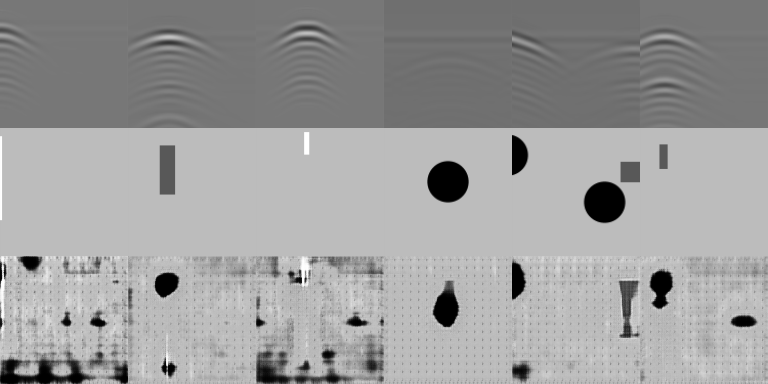

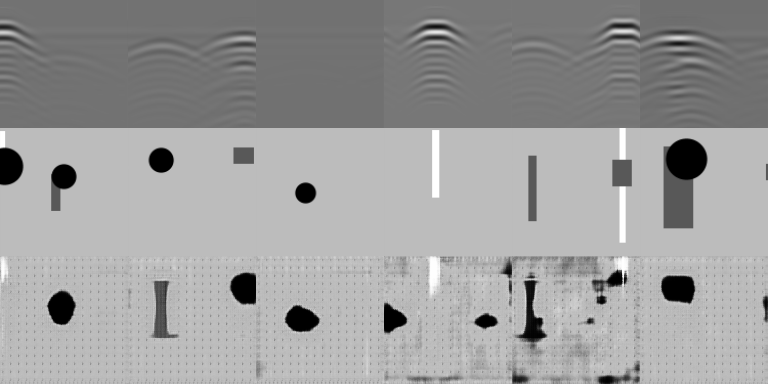

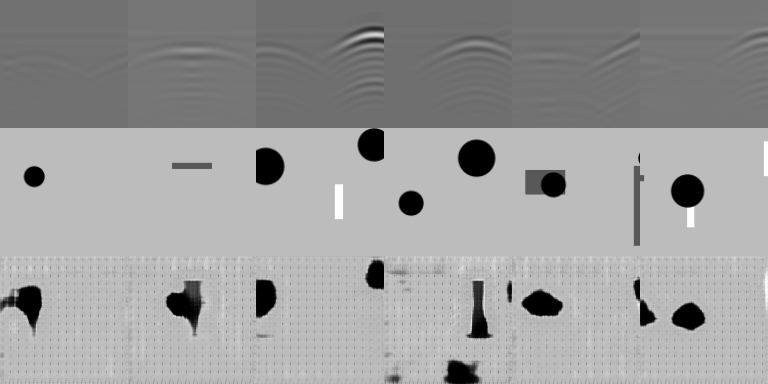

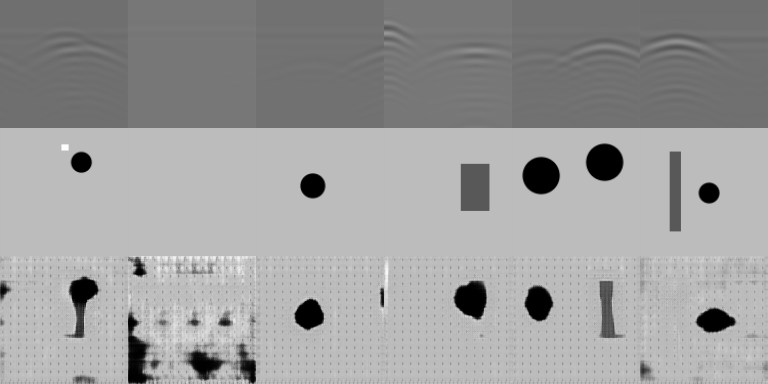

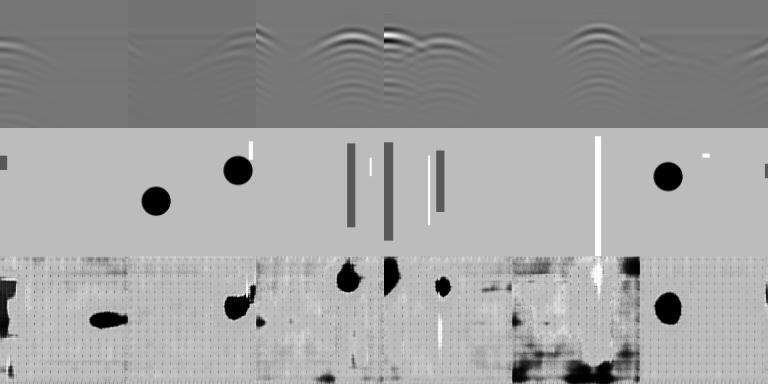

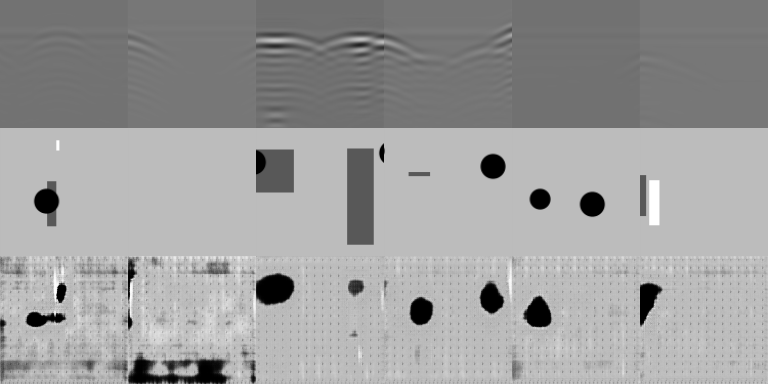

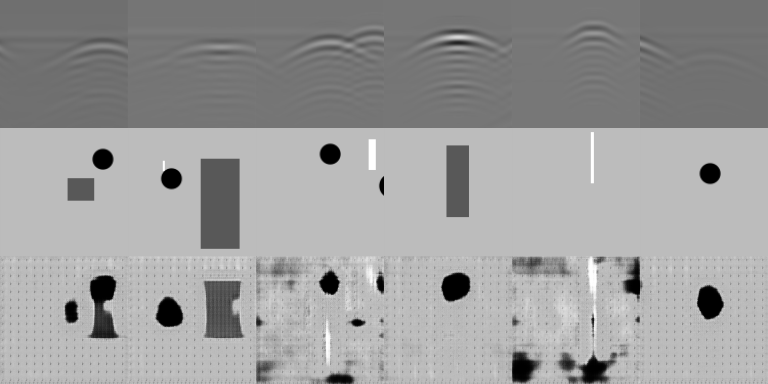

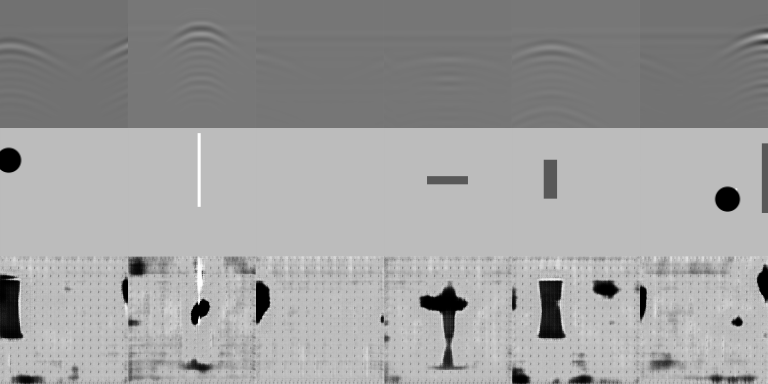

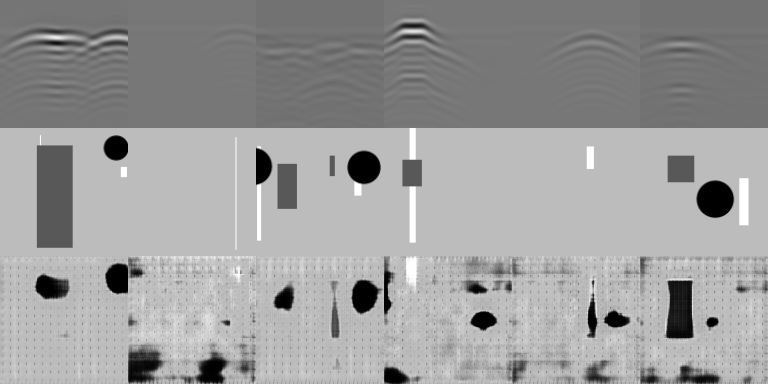

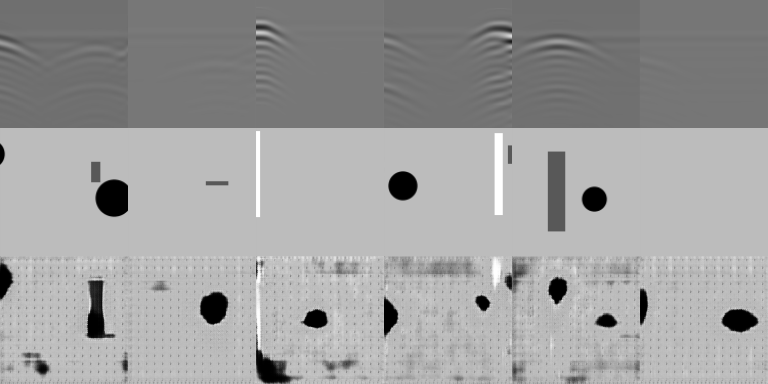

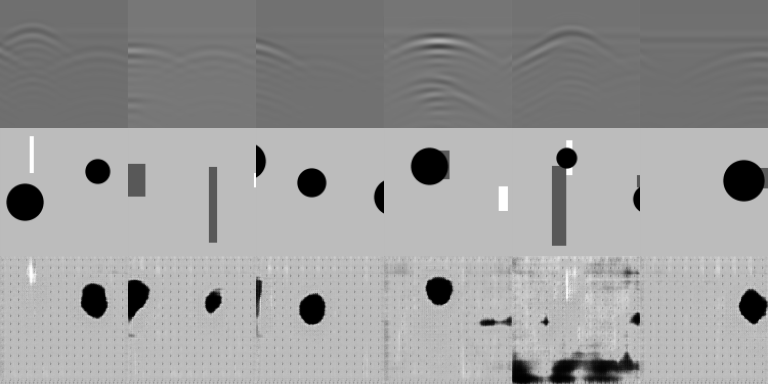

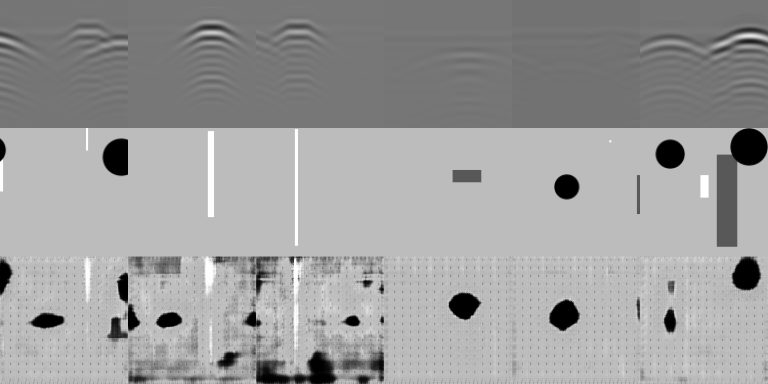

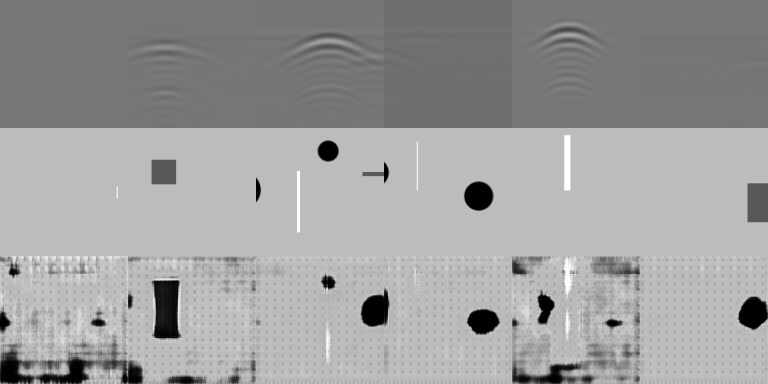

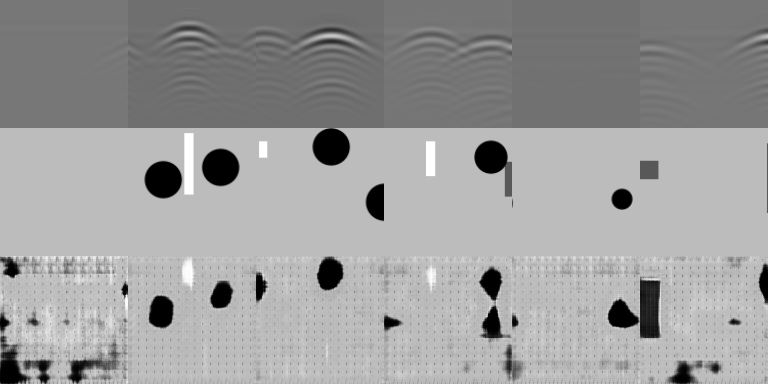

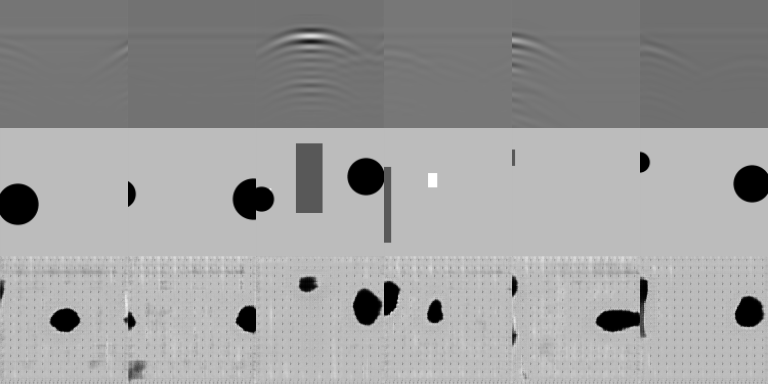

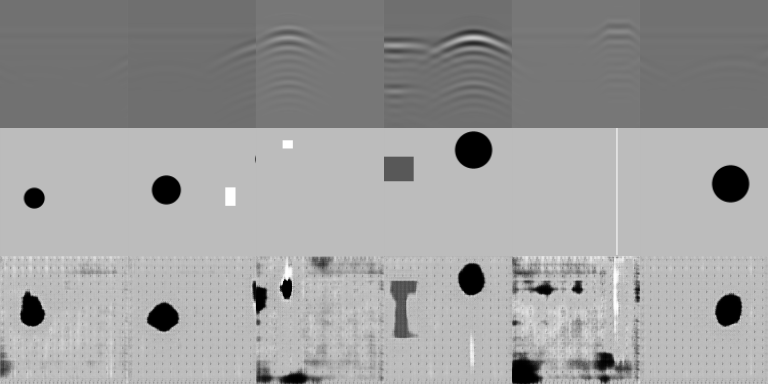

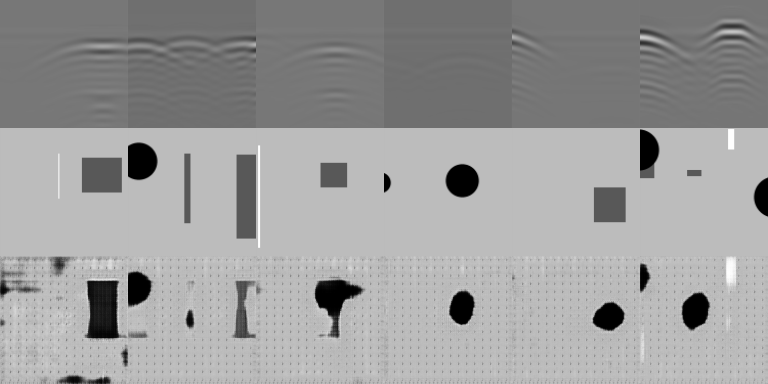

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [15]:
import utils as ut
import numpy as np

epoch = 0
val_batch = ut.minibatch(valAB, 6, imageSize, imageSize, direction)

while epoch < 1: 
    epoch, valA, valB = next(val_batch)
    valAtemp = valA.reshape(6, imageSize, imageSize, 1)
    fakeB = netG_gen(valAtemp)
    fakeB = fakeB.reshape(6, imageSize,imageSize)
    ut.show_batch_grayscale(np.concatenate([valA, valB, fakeB], axis=0), imageSize, 3)

In [ ]:
whos